In [13]:
# header

import numpy as np
import pandas as pd
from astropy.modeling import models, fitting
from astropy import units as u
from astropy.table import Table
from astropy.io import fits
from specutils.spectra import Spectrum1D, SpectralRegion
from specutils.fitting import fit_lines
from specutils.fitting.continuum import fit_continuum
from astropy.nddata.nduncertainty import StdDevUncertainty
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc

# Axis labels for Spectrum Plots
xlabel=r'rest-frame wavelength $\lambda \, [\rm{\AA}]$'
ylabel=r'$F_\lambda \,\, [10^{-16}\, \rm{ergs}^{-1}\rm{cm}^{-2}\rm{A}^{-1}]$'

In [14]:
# RF wavelengths taken from NIST (Ritz wavelength air)
Hb_rf = 4861.333
FeII4924_rf = 4924.3013  
OIII4959_rf = 4958.911 
OIII5007_rf = 5006.843
FeII5018_rf = 5018.4358
Ha_rf = 6562.819
NII6548_rf =  6548.05
NII6583_rf = 6583.45 
HeI6678_rf = 6678.151
SII6716_rf =  6715.773
SII6731_rf = 6730.816

dict_rf = {  'Hb': 4861.333,
            'FeII4924': 4924.3013,  
            'OIII4959': 4958.911, 
            'OIII5007': 5006.843,
            'FeII5018': 5018.4358,
            'Ha': 6562.819,
            'NII6548':  6548.05,
            'NII6583': 6583.45, 
            'HeI6678': 6678.151,
            'SII6716':  6715.773,
            'SII6731': 6730.816,
         }

In [90]:
class Fit_Spectrum():
    def __init__(self,file, cz):
        
        self.wvl, self.qso_spectrum, self.error = self.read_spectrum(file, cz)
        self.qso_eline, self.continuum = self.subtract_continuum(self.wvl, self.qso_spectrum)
        self.fit_range = (4750*u.nm, 5100*u.nm)
        
        self.elines = [ 'Hb_core','OIII4959_core', 'OIII5007_core', 
                        'Hb_medium', 'FeII4924_medium','FeII5018_medium',
                        'Hb_broad', 'FeII4924_broad', 'FeII5018_broad',
                        'Hb_wing', 'OIII4959_wing', 'OIII5007_wing'
                      ]
    
    # for Mrk1044 already the narrow component is blueshifted (outflow at ~180km/s)
        maxflux = np.nanmax(self.qso_eline)
        '''
        self.param_init = {
                'Hb_core' :  [maxflux*.4, Hb_rf-2,     3],
                'OIII4959_core' :      [maxflux*.1, OIII4959_rf-2,  3],
                'OIII5007_core':       [maxflux*.1, OIII5007_rf-2,  3],

                'Hb_medium':   [maxflux*.2, Hb_rf,       5],
                'FeII4924_medium':[maxflux*.1, FeII4924_rf,    5],
                'FeII5018_medium':[maxflux*.1, FeII5018_rf,    5],

                'Hb_broad':    [maxflux*.15, Hb_rf,     15],
                'FeII4924_broad': [maxflux*.02, FeII4924_rf,  15],
                'FeII5018_broad': [maxflux*.02, FeII5018_rf,  15],

                'Hb_wing':     [maxflux*.5, Hb_rf-10,    5],
                'OIII4959_wing':  [maxflux*.5, OIII4959_rf-10, 5],
                'OIII5007_wing':  [maxflux*.5, OIII5007_rf-10, 5]
                        }

        '''
        self.param_init = {
                'Hb_core' :  [maxflux*.2, Hb_rf-1,     2],
                'OIII4959_core' :      [maxflux*.2, OIII4959_rf-1,  2],
                'OIII5007_core':       [maxflux*.2, OIII5007_rf-1,  2],

                'Hb_medium':   [maxflux*.3, Hb_rf,       5],
                'FeII4924_medium':[maxflux*.1, FeII4924_rf,    5],
                'FeII5018_medium':[maxflux*.1, FeII5018_rf,    5],

                'Hb_broad':    [maxflux*.15, Hb_rf,     22],
                'FeII4924_broad': [maxflux*.05, FeII4924_rf,  22],
                'FeII5018_broad': [maxflux*.05, FeII5018_rf,  22],

                'Hb_wing':     [maxflux*.2, Hb_rf-5,    3],
                'OIII4959_wing':  [maxflux*.3, OIII4959_rf-5,  3],
                'OIII5007_wing':  [maxflux*.3, OIII5007_rf-5,  3]
                    }
    
        self.eline_models = self.setup_eline_models(self.wvl, self.param_init)
            
            
        ##############   Kinematic Coupling  #################
        
        # Line Ratios
        
        self.eline_models.OIII5007_core.amplitude.tied = self.tie_OIII5007_core_amplitude
        self.eline_models.OIII5007_wing.amplitude.tied = self.tie_OIII5007_wing_amplitude
        self.eline_models.FeII5018_medium.amplitude.tied = self.tie_FeII5018_medium_amplitude
        self.eline_models.FeII5018_broad.amplitude.tied = self.tie_FeII5018_broad_amplitude
        
        # Velocities
        self.eline_models.OIII4959_core.mean.tied = self.tie_OIII4959_core_pos
        self.eline_models.OIII5007_core.mean.tied = self.tie_OIII5007_core_pos
        self.eline_models.FeII4924_medium.mean.tied = self.tie_FeII4924_medium_pos
        self.eline_models.FeII5018_medium.mean.tied = self.tie_FeII5018_medium_pos
        self.eline_models.FeII4924_broad.mean.tied = self.tie_FeII4924_broad_pos
        self.eline_models.FeII5018_broad.mean.tied = self.tie_FeII5018_broad_pos
        self.eline_models.OIII4959_wing.mean.tied = self.tie_OIII4959_wing_pos
        self.eline_models.OIII5007_wing.mean.tied = self.tie_OIII5007_wing_pos
        
        # Dispersions
        self.eline_models.OIII4959_core.stddev.tied = self.tie_OIII4959_core_stddev
        self.eline_models.OIII5007_core.stddev.tied = self.tie_OIII5007_core_stddev
        self.eline_models.FeII4924_medium.stddev.tied = self.tie_FeII4924_medium_stddev
        self.eline_models.FeII4924_broad.stddev.tied = self.tie_FeII4924_broad_stddev
        self.eline_models.FeII5018_medium.stddev.tied = self.tie_FeII5018_medium_stddev
        self.eline_models.FeII5018_broad.stddev.tied = self.tie_FeII5018_broad_stddev
        self.eline_models.OIII4959_wing.stddev.tied = self.tie_OIII4959_wing_stddev
        self.eline_models.OIII5007_wing.stddev.tied = self.tie_OIII5007_wing_stddev
        
        
        self.compound_model = self.setup_compound_model(self.elines, self.eline_models)
        
        for i in self.compound_model:
            i.amplitude.min = 0
            
        self.model, self.model_spectrum = self.run_fit()
        
    #       Line Ratios
    # note that we couple the fluxes (amplitude * stddev), not the amplitudes!
    def tie_OIII5007_core_amplitude(self,model): return 3*model.amplitude_1#*(model.stddev_1/model.stddev_2)# couple to OIII4959
    def tie_OIII5007_wing_amplitude(self,model):  return 3*model.amplitude_10#*(model.stddev_10/model.stddev_11) # couple to OIII4959_wing
    def tie_FeII5018_medium_amplitude(self,model): return 1.29*model.amplitude_4#*(model.stddev_4/model.stddev_5) # couple to FeII4924_medium
    def tie_FeII5018_broad_amplitude(self,model): return 1.29* model.amplitude_7#*(model.stddev_7/model.stddev_8) # couple to FeII4924_broad

    #       Velocities
    # narrow
    def tie_OIII4959_core_pos(self,model): return model.mean_0 * (OIII4959_rf/Hb_rf) # couple to Hb_core
    def tie_OIII5007_core_pos(self,model): return model.mean_0 * (OIII5007_rf/Hb_rf) # couple to Hb_core
    # broad
    def tie_FeII4924_medium_pos(self,model): return model.mean_3 * (FeII4924_rf/Hb_rf)# couple to Hb_medium
    def tie_FeII5018_medium_pos(self,model): return model.mean_3 * (FeII5018_rf/Hb_rf) # couple to Hb_medium
    def tie_FeII4924_broad_pos(self,model): return model.mean_6 * (FeII4924_rf/Hb_rf) # couple to Hb_broad
    def tie_FeII5018_broad_pos(self,model): return model.mean_6 * (FeII5018_rf/Hb_rf)# couple to Hb_broad
    # outflow
    def tie_OIII4959_wing_pos(self,model):  return model.mean_9 * (OIII4959_rf/Hb_rf)# couple to Hb_wing
    def tie_OIII5007_wing_pos(self,model): return model.mean_9 * (OIII5007_rf/Hb_rf) # couple to Hb_wing

    #        Dispersions
    # narrow
    def tie_OIII4959_core_stddev(self,model): return model.stddev_0*(model.mean_1/model.mean_0)# couple to Hb_core
    def tie_OIII5007_core_stddev(self,model): return model.stddev_0*(model.mean_2/model.mean_0)  # couple to Hb narrow
    # broad
    def tie_FeII4924_medium_stddev(self,model):  return model.stddev_3*(model.mean_4/model.mean_3)   # couple to Hb_medium
    def tie_FeII5018_medium_stddev(self,model): return model.stddev_3*(model.mean_5/model.mean_3)  # couple to Hb medium
    def tie_FeII4924_broad_stddev(self,model):  return model.stddev_6*(model.mean_7/model.mean_6) # couple to Hb_broad
    def tie_FeII5018_broad_stddev(self,model): return model.stddev_6*(model.mean_8/model.mean_6)  # couple to FeII4924_broad
    # wing
    def tie_OIII4959_wing_stddev(self,model): return model.stddev_9*(model.mean_10/model.mean_9) # couple to Hb_wing
    def tie_OIII5007_wing_stddev(self,model):  return model.stddev_9*(model.mean_11/model.mean_9) # couple to Hb_wing

    
    
            ##############################################
    
    def read_spectrum(self, file, cz):
        
        with fits.open(file) as hdul:
            wvl = hdul[0].data/(1+cz/3e5)
            spec = hdul[1].data
            err = hdul[2].data
        
        return wvl, spec, err

    def subtract_continuum(self,wvl,spectrum):
        
        continuum_rf = {1:[4750,4755], 4:[5080,5090]}
        
        select_cont = np.zeros(wvl.shape).astype(bool)
        for i in continuum_rf:
            select_cont = select_cont + ((wvl> continuum_rf[i][0]) & 
                                         (wvl< continuum_rf[i][1])
                                        )

        fit = fitting.LinearLSQFitter() # initialize linear fitter
        line_init=models.Polynomial1D(degree=1) 

        cont_model = fit(line_init, wvl[select_cont], spectrum[select_cont])
        cont = cont_model(wvl) 

        eline = spectrum - cont
        eline_norm = eline/np.nansum(eline)
        
        return eline, cont

    
    def setup_eline_models(self, wvl, param):
        
        eline_models = type('', (), {})() # empty object
        
        for i in self.param_init:
            gauss = models.Gaussian1D(param[i][0]*u.Jy, param[i][1]*u.nm,param[i][2]*u.nm)
            setattr(eline_models, i, gauss)
        
        return eline_models
    
    def setup_compound_model(self, elines, eline_models):
        
        # from all emission lines found in the QSO spectrum
        # this function kinematically ties the components that stem from the same region
        
        # get all eline_models in component
        basemodels = np.full(len(elines), models.Gaussian1D())
        for idx, eline in enumerate(elines):
            basemodels[idx] = getattr(self.eline_models, eline)

        # compound model
        for idx in range(len(basemodels))[1:]: # add all models to first element in array
            basemodels[0] += basemodels[idx]
            
        compound_model = basemodels[0]
        
        return compound_model
    
    def run_fit(self):
 
        spectrum = Spectrum1D(flux=self.qso_eline*u.Jy, spectral_axis=self.wvl*u.nm, uncertainty = StdDevUncertainty(self.error))
     
        model = fit_lines(spectrum, self.compound_model, window=self.fit_range, weights='unc')
        model_spectrum = model(self.wvl*u.nm)
        
        return model, model_spectrum
    
    def write(self, path=None):
        
        # (1) par_table
        
        if path==None: raise ValueError('specify path to write output file!') 
        
        t = Table([['amplitude', 'mean', 'stddev'],
                   *[(self.model[i].parameters) for i in range(len(self.elines))]],
                    names=('parameter', *self.elines)
                  )
            
        t.write(path+'par_table.fits', overwrite=True)
        
        # (2) best_model_components
        
        t = Table()
        t['wvl'] = self.wvl
        for idx,eline in enumerate(self.elines):
            t[eline] = self.model[idx](self.wvl*u.nm).value
            
        t.write(path+'best_model_components.fits', overwrite=True)
        
    def set_rc_params(self,mult=1):
        mult = 1
        mpl.rcParams.update({'font.size': 15*mult})
        mpl.rcParams['legend.fontsize'] = 15*mult
        mpl.rcParams['axes.linewidth'] = 1
        mpl.rcParams['xtick.labelsize'] = 15*mult
        mpl.rcParams['ytick.labelsize'] = 15*mult
        mpl.rcParams['xtick.major.size'] = 5
        mpl.rcParams['ytick.major.size'] = 5
        mpl.rcParams['xtick.major.width'] = 1
        mpl.rcParams['ytick.major.width'] = 1
        mpl.rcParams['xtick.minor.size'] = 3
        mpl.rcParams['ytick.minor.size'] = 3
        mpl.rcParams['xtick.minor.width'] = 1
        mpl.rcParams['ytick.minor.width'] = 1
        mpl.rcParams['xtick.direction'] = 'in'
        mpl.rcParams['ytick.direction'] = 'in'
        mpl.rcParams['xtick.bottom'] = True
        mpl.rcParams['ytick.left'] = True
        mpl.rcParams['axes.labelsize'] = 15*mult
        mpl.rcParams['text.usetex'] = True
        
        
    def plot_model(self,axes=None):
        
        self.set_rc_params()
        
        # get line parameters from compound model
        Hbeta_narrow_fit = self.model[0](self.wvl*u.nm)
        OIII4959_fit = self.model[1](self.wvl*u.nm)
        OIII5007_fit = self.model[2](self.wvl*u.nm)

        Hbeta_medium_fit = self.model[3](self.wvl*u.nm)
        FeII4924_medium_fit = self.model[4](self.wvl*u.nm)
        FeII5018_medium_fit = self.model[5](self.wvl*u.nm)

        Hbeta_broad_fit = self.model[6](self.wvl*u.nm)
        FeII4924_broad_fit = self.model[7](self.wvl*u.nm)
        FeII5018_broad_fit = self.model[8](self.wvl*u.nm)

        Hbeta_wing_fit = self.model[9](self.wvl*u.nm)
        OIII4959_wing_fit = self.model[10](self.wvl*u.nm)
        OIII5007_wing_fit = self.model[11](self.wvl*u.nm)
    
    
        # Plot
        fig,axes=plt.subplots(1,1,sharey=True,figsize=(6,4), dpi=200)
        
        plt.step(self.wvl+1.25/2, self.qso_spectrum, c='k', label='AGN')
        plt.plot(self.wvl, self.model_spectrum + self.continuum*u.Jy, '-', linewidth=1, c='red', label=r'Compound Model')

        plt.plot(self.wvl, Hbeta_narrow_fit, '-.', linewidth=0.5, c='m', label=r'H$\beta$ core')
        plt.plot(self.wvl, Hbeta_medium_fit, '--', linewidth=.5, c='m', label=r'H$\beta$ medium')
        plt.plot(self.wvl, Hbeta_broad_fit, '-', linewidth=.5, c='m', label=r'H$\beta$ broad')
        plt.plot(self.wvl, Hbeta_wing_fit, '.', markersize=0.5, c='m', label=r'H$\beta$ wing')

        plt.plot(self.wvl, OIII4959_fit, '-.', linewidth=.5, c='green', label=r'OIII4959 core')
        plt.plot(self.wvl, OIII4959_wing_fit, '.', markersize=.5, c='green', label=r'OIII4959 wing')
        plt.plot(self.wvl, OIII5007_fit, '-.', linewidth=.5, c='darkgreen', label=r'OIII5007 core')
        plt.plot(self.wvl, OIII5007_wing_fit, '.', markersize=.5, c='darkgreen', label=r'OIII5007 wing')

        plt.plot(self.wvl, FeII4924_medium_fit, '--', linewidth=.5, c='blue', label=r'FeII4924 medium')
        plt.plot(self.wvl, FeII4924_broad_fit, '-', linewidth=.5, c='blue', label=r'FeII4924 broad')
        plt.plot(self.wvl, FeII5018_medium_fit, '--', linewidth=.5, c='darkblue', label=r'FeII5018 medium')
        plt.plot(self.wvl, FeII5018_broad_fit, '-', linewidth=.5, c='darkblue', label=r'FeII5018 broad')

        plt.legend(fontsize=6)
        plt.xlim(self.fit_range[0].value, self.fit_range[1].value)
        
        plt.xlabel(xlabel, fontsize=15)
        plt.ylabel(ylabel, fontsize=15)
        
        return fig

# Mrk 1044

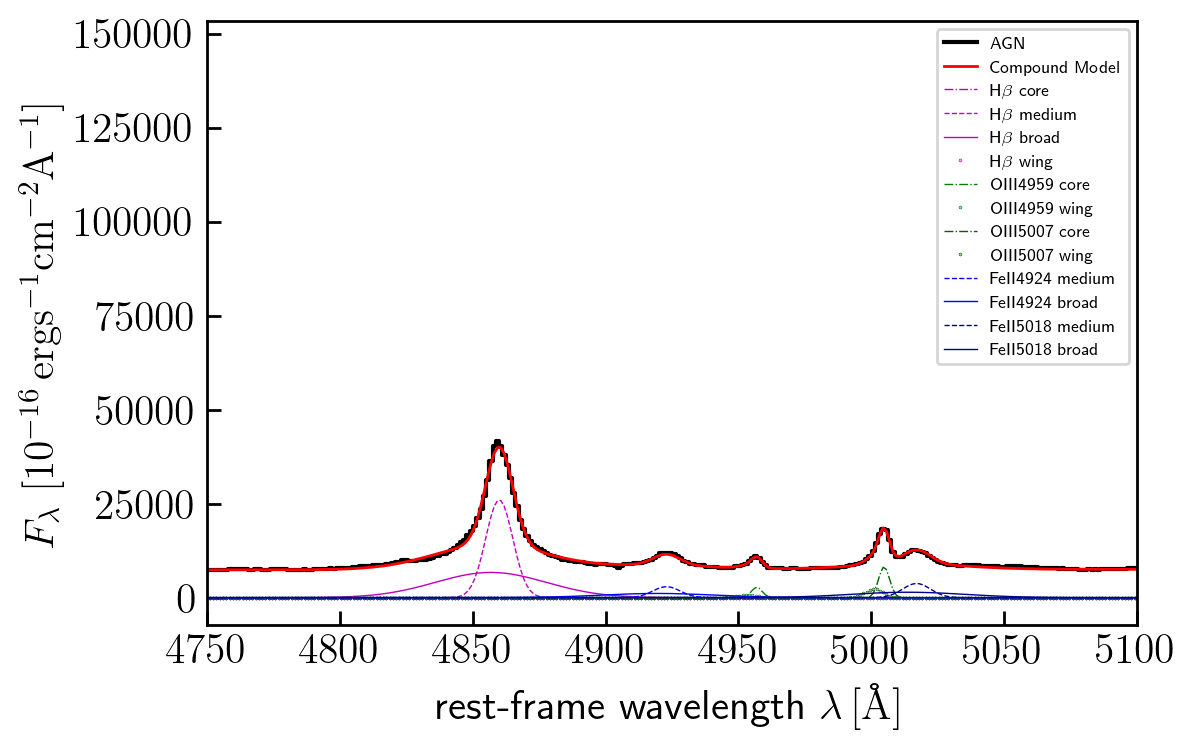

In [91]:
file = '/home/winkel/Projects/MUSE_NFM_AGN/02_AGN/00_AGN_Spec_blended/Data/HE0227-0913/Mrk1044_AGN_spectrum.fits'

cz = 4913.4

fit_spectrum = Fit_Spectrum(file, cz)
fig = fit_spectrum.plot_model(fit_spectrum)
dirname1 = 'HE0227-0913/'
objectname='Mrk1044'
fig.savefig('example/fit_spec.png', bbox_inches='tight')

In [92]:
# save line parameters
fit_spectrum.write('example/')

In [ ]:
Hbeta_sys = Hb_rf*(cz/3e5+1)

v_narrow = ((fit_spectrum.model[0].mean.value-Hbeta_sys)/ Hbeta_sys) *3e5
v_medium = ((fit_spectrum.model[3].mean.value-Hbeta_sys)/ Hbeta_sys) *3e5
v_broad = ((fit_spectrum.model[6].mean.value-Hbeta_sys)/ Hbeta_sys) *3e5
v_wing = (fit_spectrum.model[9].mean.value-Hbeta_sys)/ Hbeta_sys *3e5

sigma_narrow = ((fit_spectrum.model[0].stddev.value)/2.35/ Hbeta_sys) *3e5
sigma_medium = ((fit_spectrum.model[3].stddev.value)/2.35/ Hbeta_sys) *3e5
sigma_broad = ((fit_spectrum.model[6].stddev.value)/2.35/ Hbeta_sys) *3e5
sigma_wing = (fit_spectrum.model[9].stddev.value)/2.35/ Hbeta_sys *3e5


print('%15s %.10s %.10s ' %('component ','v [kms-1]', 'σ [kms-1]'))
print('%.40s' %('-'*40))
print('%15s %8.1f %8.1f' %('broad: ' ,v_broad,  sigma_broad))
print('%15s %8.1f %8.1f' %('medium: ',v_medium, sigma_medium))
print('%15s %8.1f %8.1f' %('core: ',v_narrow, sigma_narrow))
print('%15s %8.1f %8.1f' %('wing: ',v_wing,   sigma_wing))

### Load Data for HE1029-1401

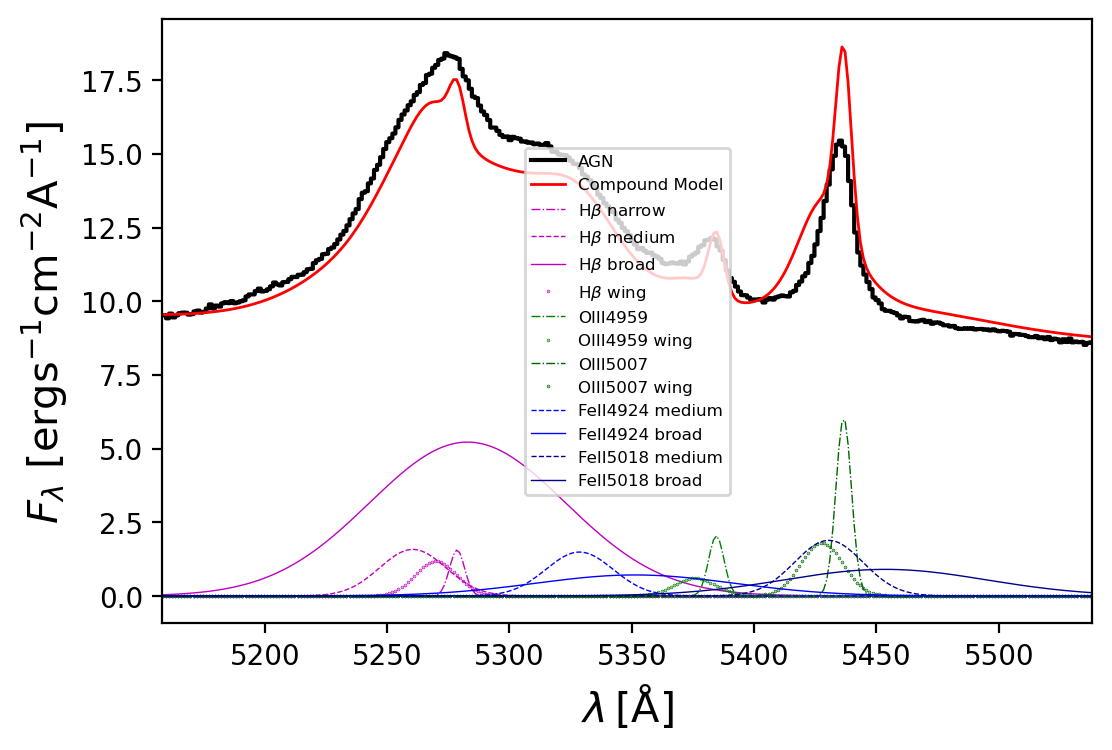

In [126]:
root = '/home/winkel/Projects/MUSE_NFM_AGN/02_AGN/01_AGN_Spec/Data/'

dirname1 = 'HE1029-1401/'
objectname='HE1029-1401'
df = pd.read_csv(root+dirname1+'HE1029-1401_AGN_spectrum_1x1_px.csv')

x = np.array(df['wvl'][:1000])
y = np.array(df['flux'][:1000])/1e4
dy = np.array(df['dflux'][:1000])/1e4
cz = 25782
redshift=cz/3e5

maxflux = np.nanmax(y-np.nanmedian(y))
param_init = {
        'Hbeta_narrow' :  [maxflux*.1, Hbeta_rf*(1+cz/3e5)-2,     3],
        'OIII4959' :      [maxflux*.2, OIII4959_rf*(1+cz/3e5)-2,  3],
        'OIII5007':       [maxflux*.2, OIII5007_rf*(1+cz/3e5)-2,  3],

        'Hbeta_medium':   [maxflux*.1, Hbeta_rf*(1+cz/3e5)-20,       10],
        'FeII4924_medium':[maxflux*.1, FeII4924_rf*(1+cz/3e5)-20,    10],
        'FeII5018_medium':[maxflux*.1, FeII5018_rf*(1+cz/3e5)-20,    10],

        'Hbeta_broad':    [maxflux*.5, Hbeta_rf*(1+cz/3e5),     35],
        'FeII4924_broad': [maxflux*.01, FeII4924_rf*(1+cz/3e5),  35],
        'FeII5018_broad': [maxflux*.01, FeII5018_rf*(1+cz/3e5),  35],

        'Hbeta_wing':     [maxflux*.05, Hbeta_rf*(1+cz/3e5)-5,    5],
        'OIII4959_wing':  [maxflux*.02, OIII4959_rf*(1+cz/3e5)-5, 5],
        'OIII5007_wing':  [maxflux*.05, OIII5007_rf*(1+cz/3e5)-5, 5]
                }

fit_spectrum = Fit_Spectrum(x,y,dy,cz,param_init)
fig = Plot.plot_model(fit_spectrum)

### Load Data for NGC4593

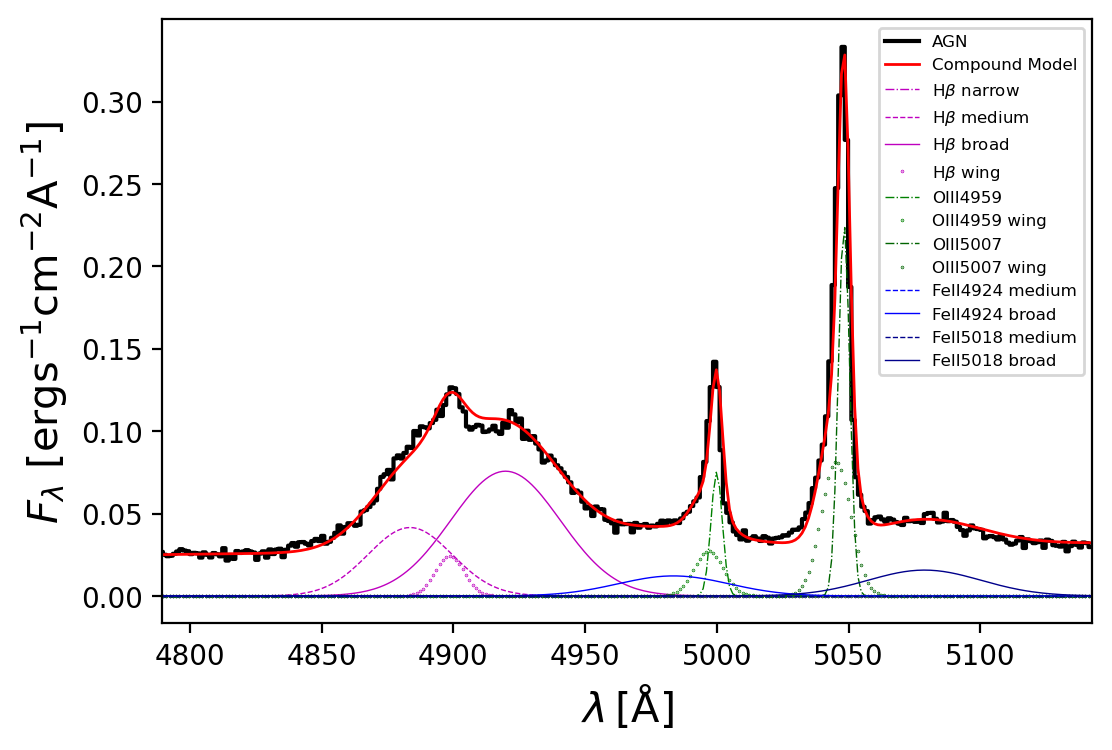

In [156]:
root = '/home/winkel/Projects/MUSE_NFM_AGN/02_AGN/01_AGN_Spec/Data/'

dirname1 = 'HE1237-0504/'
objectname='NGC4593'
df = pd.read_csv(root+dirname1+'NGC4593_AGN_spectrum_1x1_px.csv')

x = np.array(df['wvl'][:1000])
y = np.array(df['flux'][:1000])/1e4
dy = np.array(df['dflux'][:1000])/1e4

cz = 2501
redshift=cz/3e5

maxflux = np.nanmax(y-np.nanmedian(y))
param_init = {
        'Hbeta_narrow' :  [maxflux*.1, Hbeta_rf*(1+cz/3e5)-2,     3],
        'OIII4959' :      [maxflux*.2, OIII4959_rf*(1+cz/3e5)-2,  3],
        'OIII5007':       [maxflux*.2, OIII5007_rf*(1+cz/3e5)-2,  3],

        'Hbeta_medium':   [maxflux*.1, Hbeta_rf*(1+cz/3e5)-10,       10],
        'FeII4924_medium':[maxflux*.1, FeII4924_rf*(1+cz/3e5)-10,    10],
        'FeII5018_medium':[maxflux*.1, FeII5018_rf*(1+cz/3e5)-10,    10],

        'Hbeta_broad':    [maxflux*.1, Hbeta_rf*(1+cz/3e5),     35],
        'FeII4924_broad': [maxflux*.01, FeII4924_rf*(1+cz/3e5),  35],
        'FeII5018_broad': [maxflux*.01, FeII5018_rf*(1+cz/3e5),  35],

        'Hbeta_wing':     [maxflux*.05, Hbeta_rf*(1+cz/3e5)-10,    5],
        'OIII4959_wing':  [maxflux*.02, OIII4959_rf*(1+cz/3e5)-10, 5],
        'OIII5007_wing':  [maxflux*.05, OIII5007_rf*(1+cz/3e5)-10, 5]
                }

fit_spectrum = Fit_Spectrum(x,y,dy,cz,param_init)
fig = Plot.plot_model(fit_spectrum)

### Load Data for MR2251-178

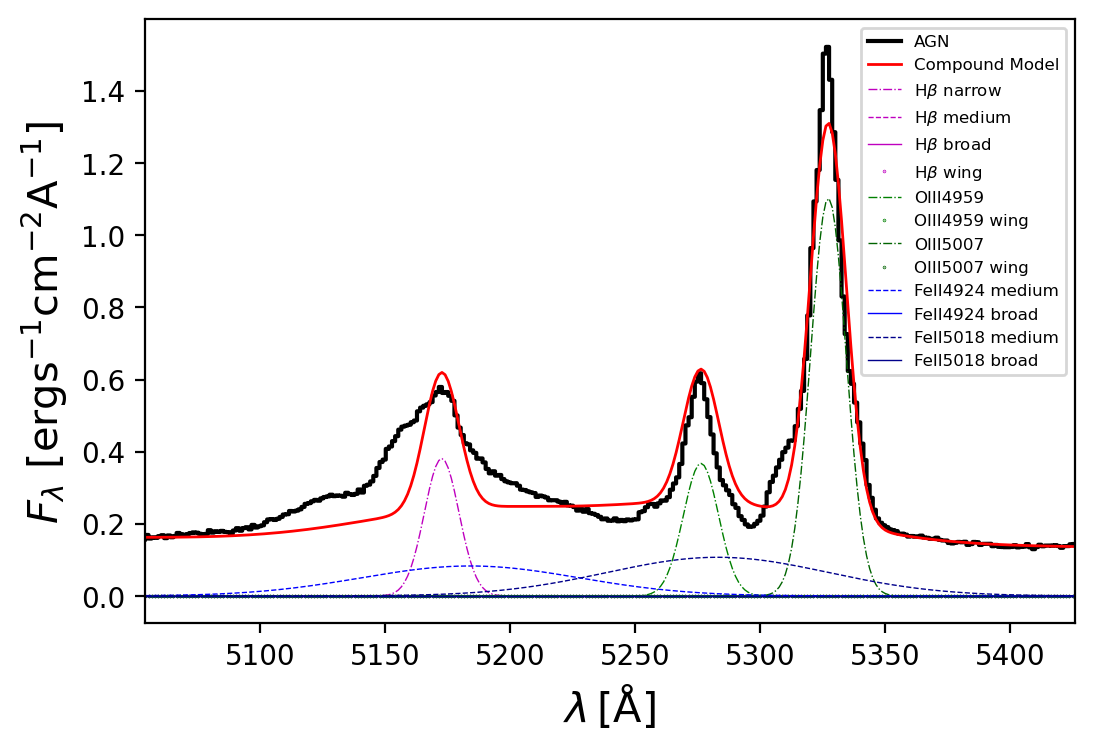

In [158]:
root = '/home/winkel/Projects/MUSE_NFM_AGN/02_AGN/01_AGN_Spec/Data/'

dirname1 = 'MR2251-178/'
objectname='MR2251-178'
df = pd.read_csv(root+dirname1+'MR2251-178_AGN_spectrum_1x1_px.csv')

x = np.array(df['wvl'][:1000])
y = np.array(df['flux'][:1000])/1e4
dy = np.array(df['dflux'][:1000])/1e4
redshift=0.06398

cz = 19180
redshift=cz/3e5

maxflux = np.nanmax(y-np.nanmedian(y))
param_init = {
        'Hbeta_narrow' :  [maxflux*.1, Hbeta_rf*(1+cz/3e5)-2,     3],
        'OIII4959' :      [maxflux*.2, OIII4959_rf*(1+cz/3e5)-2,  3],
        'OIII5007':       [maxflux*.2, OIII5007_rf*(1+cz/3e5)-2,  3],

        'Hbeta_medium':   [maxflux*.1, Hbeta_rf*(1+cz/3e5)-5,       10],
        'FeII4924_medium':[maxflux*.1, FeII4924_rf*(1+cz/3e5)-5,    10],
        'FeII5018_medium':[maxflux*.1, FeII5018_rf*(1+cz/3e5)-5,    10],

        'Hbeta_broad':    [maxflux*.1, Hbeta_rf*(1+cz/3e5),     35],
        'FeII4924_broad': [maxflux*.01, FeII4924_rf*(1+cz/3e5),  35],
        'FeII5018_broad': [maxflux*.01, FeII5018_rf*(1+cz/3e5),  35],

        'Hbeta_wing':     [maxflux*.05, Hbeta_rf*(1+cz/3e5)-20,    5],
        'OIII4959_wing':  [maxflux*.02, OIII4959_rf*(1+cz/3e5)-20, 5],
        'OIII5007_wing':  [maxflux*.05, OIII5007_rf*(1+cz/3e5)-20, 5]
                }

fit_spectrum = Fit_Spectrum(x,y,dy,cz,param_init)
fig = Plot.plot_model(fit_spectrum)

(4750.0, 5100.0)

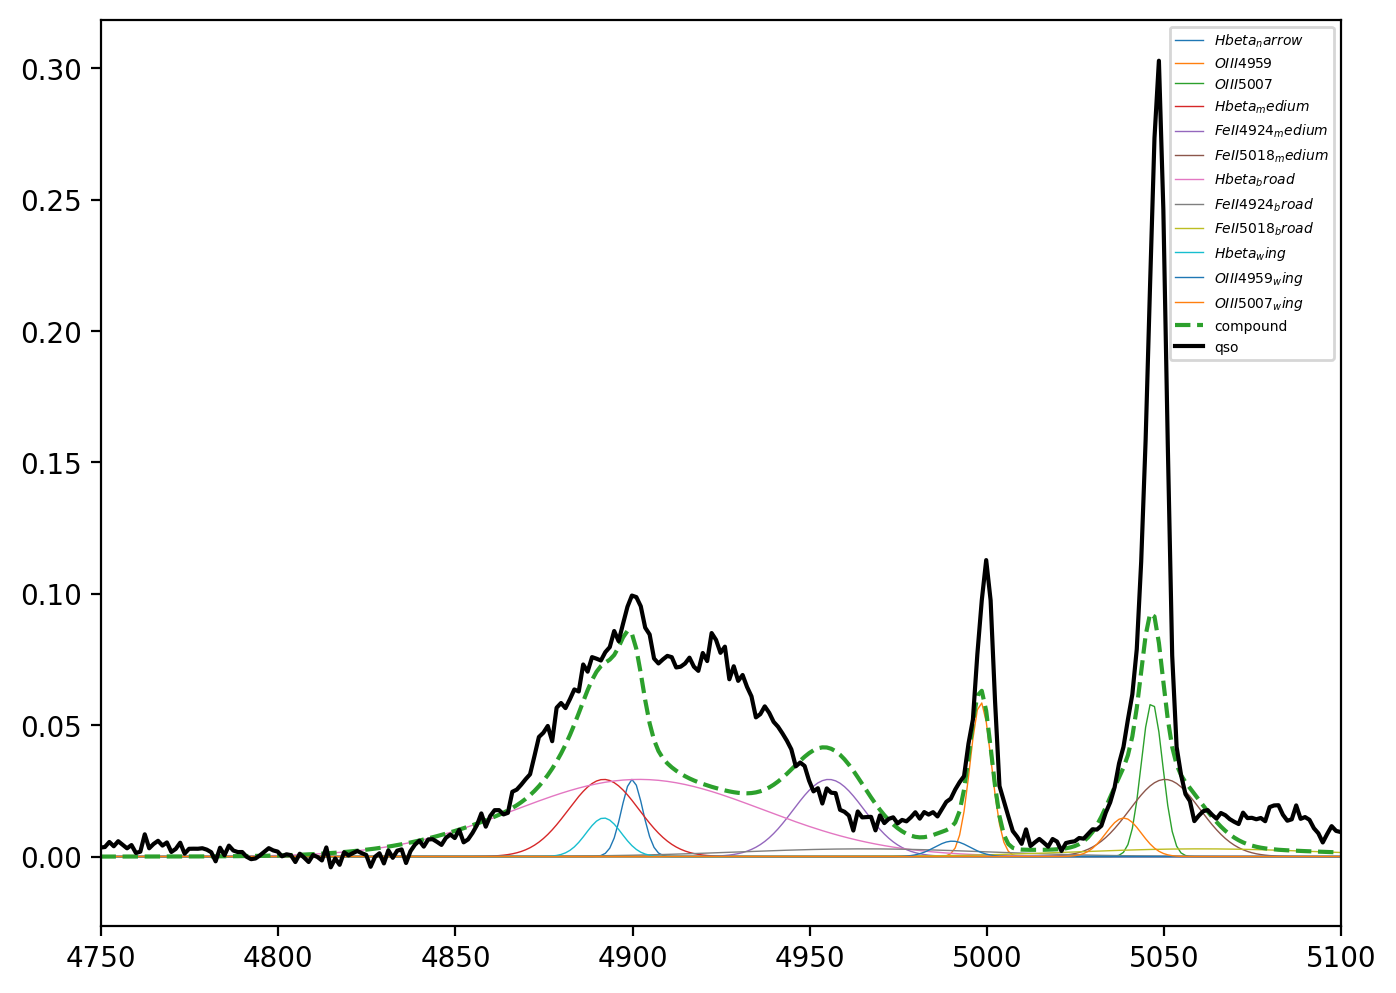

In [157]:
fig, axes = plt.subplots(figsize=(8,6), dpi=200)
for idx,i in enumerate(fit_spectrum.compound_model):
    plt.plot(x,i(x*u.nm), linewidth=.5,label=r'$'+fit_spectrum.elines[idx]+'$')
plt.plot(x,fit_spectrum.compound_model(x*u.nm), linestyle='--', label = 'compound')
plt.plot(x, fit_spectrum.qso_eline, c='k',label='qso')
plt.legend(fontsize=5)
plt.xlim(4750,5100)

### Load Data for Mrk1298

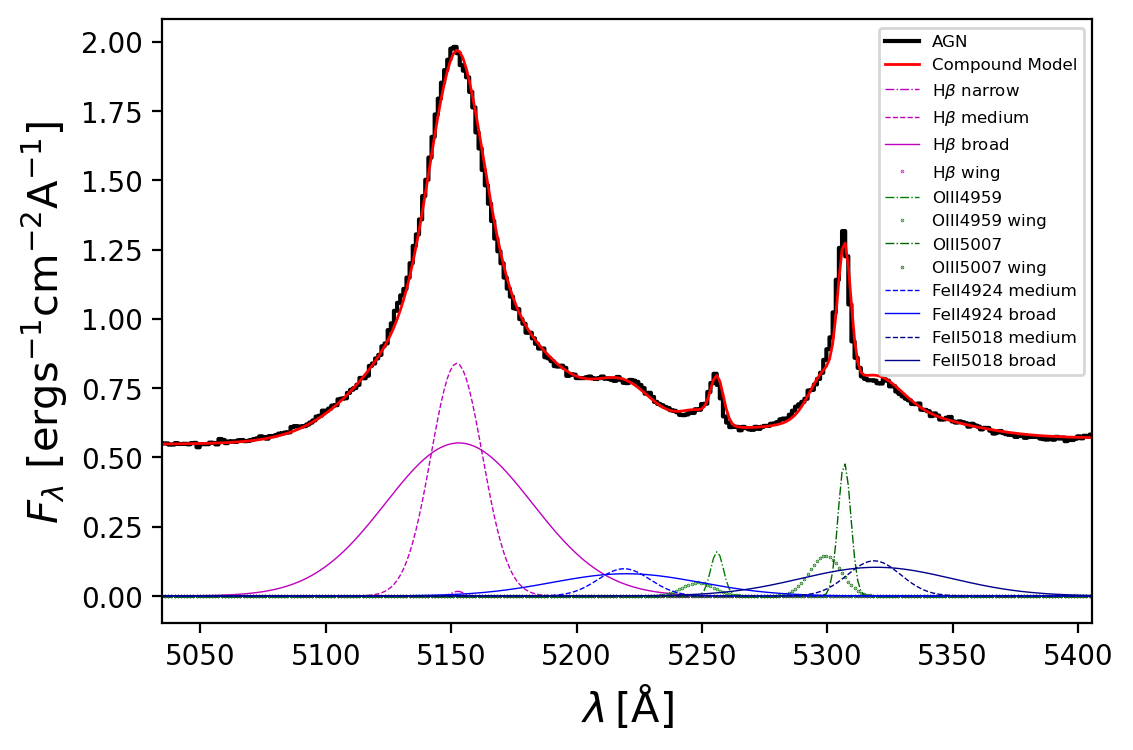

In [141]:
root = '/home/winkel/Projects/MUSE_NFM_AGN/02_AGN/01_AGN_Spec/Data/'

dirname1 = 'Mrk1298/'
objectname='PG1126-041'
df = pd.read_csv(root+dirname1+'PG1126-041_AGN_spectrum_1x1_px.csv')

x = np.array(df['wvl'][:1000])
y = np.array(df['flux'][:1000])/1e4
dy = np.array(df['flux'][:1000])/1e4
redshift=0.060

cz =  17988 
redshift=cz/3e5

maxflux = np.nanmax(y-np.nanmedian(y))
param_init = {
        'Hbeta_narrow' :  [maxflux*.1, Hbeta_rf*(1+cz/3e5)-2,     3],
        'OIII4959' :      [maxflux*.2, OIII4959_rf*(1+cz/3e5)-2,  3],
        'OIII5007':       [maxflux*.2, OIII5007_rf*(1+cz/3e5)-2,  3],

        'Hbeta_medium':   [maxflux*.1, Hbeta_rf*(1+cz/3e5),       10],
        'FeII4924_medium':[maxflux*.1, FeII4924_rf*(1+cz/3e5),    10],
        'FeII5018_medium':[maxflux*.1, FeII5018_rf*(1+cz/3e5),    10],

        'Hbeta_broad':    [maxflux*.5, Hbeta_rf*(1+cz/3e5),      35],
        'FeII4924_broad': [maxflux*.01, FeII4924_rf*(1+cz/3e5),  35],
        'FeII5018_broad': [maxflux*.01, FeII5018_rf*(1+cz/3e5),  35],

        'Hbeta_wing':     [maxflux*.05, Hbeta_rf*(1+cz/3e5)-5,    5],
        'OIII4959_wing':  [maxflux*.02, OIII4959_rf*(1+cz/3e5)-5, 5],
        'OIII5007_wing':  [maxflux*.05, OIII5007_rf*(1+cz/3e5)-5, 5]
                }

fit_spectrum = Fit_Spectrum(x,y,dy,cz,param_init)
fig = Plot.plot_model(fit_spectrum)

### Load Data for 1Zw I

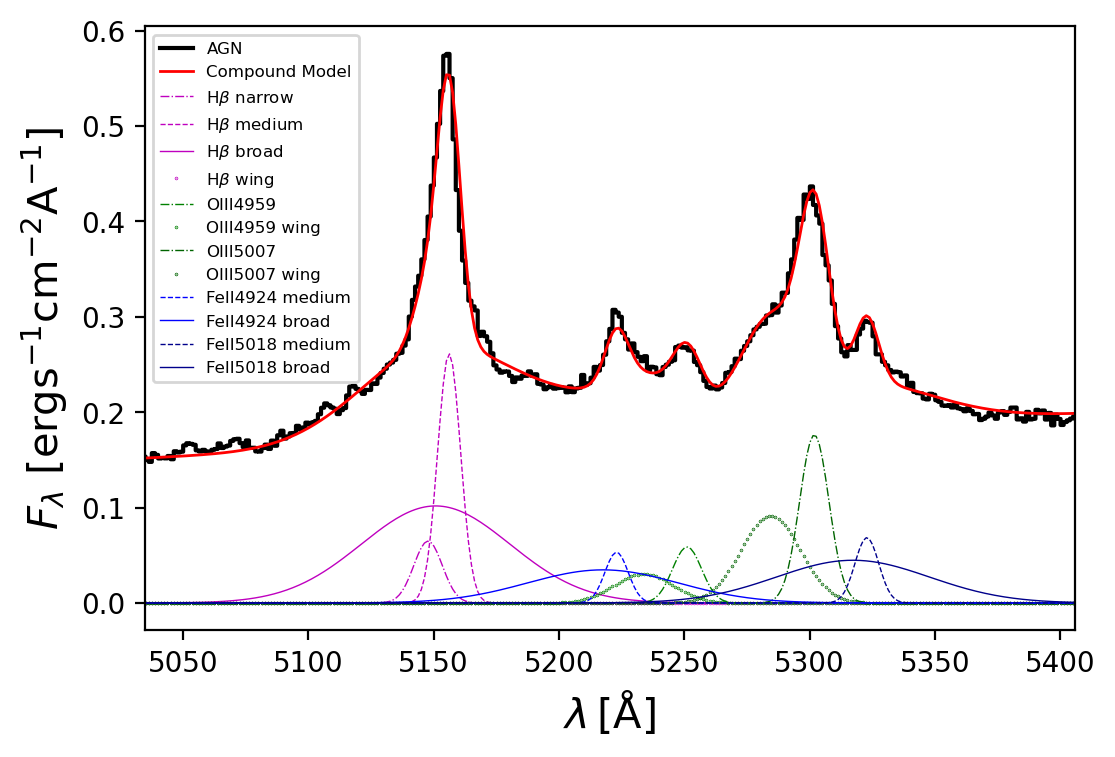

In [139]:
root = '/home/winkel/Projects/MUSE_NFM_AGN/02_AGN/01_AGN_Spec/Data/'

dirname1 = 'Mrk1502/'
objectname='Mrk1502'
df = pd.read_csv(root+dirname1+'Mrk1502_AGN_spectrum_1x1_px.csv')

x = np.array(df['wvl'][:1000])
y = np.array(df['flux'][:1000])/1e4
dy = np.array(df['flux'][:1000])/1e4

cz = 17988
redshift=cz/3e5

maxflux = np.nanmax(y-np.nanmedian(y))
param_init = {
        'Hbeta_narrow' :  [maxflux*.1, Hbeta_rf*(1+cz/3e5)-2,     3],
        'OIII4959' :      [maxflux*.2, OIII4959_rf*(1+cz/3e5)-2,  3],
        'OIII5007':       [maxflux*.2, OIII5007_rf*(1+cz/3e5)-2,  3],

        'Hbeta_medium':   [maxflux*.1, Hbeta_rf*(1+cz/3e5),       10],
        'FeII4924_medium':[maxflux*.1, FeII4924_rf*(1+cz/3e5),    10],
        'FeII5018_medium':[maxflux*.1, FeII5018_rf*(1+cz/3e5),    10],

        'Hbeta_broad':    [maxflux*.1, Hbeta_rf*(1+cz/3e5),     20],
        'FeII4924_broad': [maxflux*.01, FeII4924_rf*(1+cz/3e5),  20],
        'FeII5018_broad': [maxflux*.01, FeII5018_rf*(1+cz/3e5),  20],

        'Hbeta_wing':     [maxflux*.05, Hbeta_rf*(1+cz/3e5)-5,    5],
        'OIII4959_wing':  [maxflux*.02, OIII4959_rf*(1+cz/3e5)-5, 5],
        'OIII5007_wing':  [maxflux*.05, OIII5007_rf*(1+cz/3e5)-5, 5]
                }

fit_spectrum = Fit_Spectrum(x,y,dy,cz,param_init)
fig = Plot.plot_model(fit_spectrum)

# Script

### Define the regions to fit the continuum in rest-frame

In [35]:
root = '/home/winkel/Projects/MUSE_NFM_AGN/02_AGN/01_AGN_Spec/Data/'

dirname1 = 'HE0227-0913/'
objectname='Mrk1044'
df = pd.read_csv(root+dirname1+'Mrk1044_AGN_spectrum_1x1_px.csv')

x = np.array(df['wvl'][:1000])
y = np.array(df['flux'][:1000])/1e4 #bring to 10-16 ergs-1-cm-2-A
dy = np.array(df['flux'][:1000])/1e4
cz = 4913.4
redshift=cz/3e5

maxflux = np.nanmax(y)
init = {
        'Hbeta_narrow' :  [maxflux*.4, -20,  30],
        'OIII4959_narrow' :      [maxflux*.1, -20,  30],
        'OIII5007_narrow':       [maxflux*.1, -20,  30],

        'Hbeta_medium':   [maxflux*.2, 0,    100],
        'FeII4924_medium':[maxflux*.1, 0,    100],
        'FeII5018_medium':[maxflux*.1, 0,    100],

        'Hbeta_broad':    [maxflux*.15, 0,  200],
        'FeII4924_broad': [maxflux*.02, 0,  200],
        'FeII5018_broad': [maxflux*.02, 0,  200],

        'Hbeta_wing':     [maxflux*.05, -100,  30],
        'OIII4959_wing':  [maxflux*.02, -100,  30],
        'OIII5007_wing':  [maxflux*.05, -100,  30]
                }

In [27]:
regions_continuum_rf = {1:[4745,4750], 4:[5080,5090]
                       }

regions_continuum = np.zeros(x.shape).astype(bool)
for i in regions_continuum_rf:
    regions_continuum = regions_continuum + ((x> regions_continuum_rf[i][0]*(1+redshift)) & 
                                             (x< regions_continuum_rf[i][1]*(1+redshift))
                                            )

Text(0, 0.5, '$F_\\lambda \\,\\, [\\rm{ergs}^{-1}\\rm{cm}^{-2}\\rm{A}^{-1}]$')

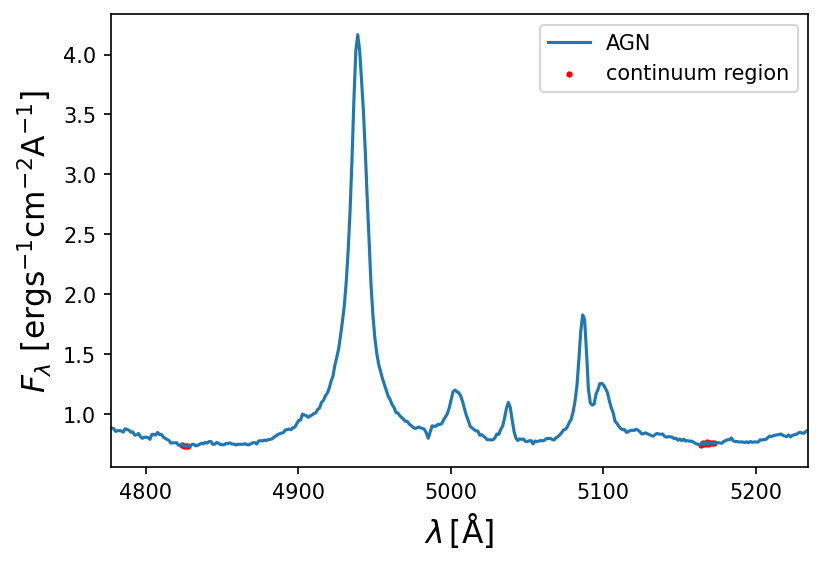

In [28]:
fig = plt.figure(figsize=(6, 4), dpi=150)

plt.plot(x,y, label='AGN')
plt.scatter(x[regions_continuum],y[regions_continuum], c='r', s=4, label='continuum region')
plt.legend()
plt.xlim(4700*(1+redshift),5150*(1+redshift))
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)

In [29]:
# initialize linear fitter
fit=fitting.LinearLSQFitter()

# initialize a polynomial model
line_init=models.Polynomial1D(degree=1)

continuum_model=fit(line_init, x[regions_continuum], y[regions_continuum],weights=1/dy[regions_continuum])
y_continuum=continuum_model(x)
y_lines=y-y_continuum

Text(0, 0.5, '$F_\\lambda \\,\\, [\\rm{ergs}^{-1}\\rm{cm}^{-2}\\rm{A}^{-1}]$')

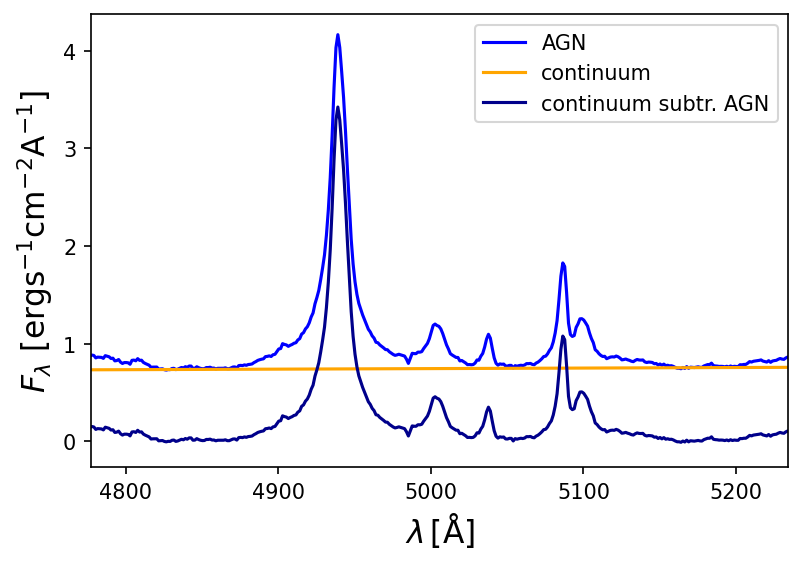

In [30]:
fig = plt.figure(figsize=(6, 4), dpi=150)

plt.plot(x,y, c='blue', label= 'AGN')
plt.plot(x, y_continuum, c='orange', label= 'continuum')
plt.plot(x, y_lines, c='darkblue', label='continuum subtr. AGN')
plt.legend()
plt.xlim(4700*(1+redshift),5150*(1+redshift))
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)

## Fit Emission Lines

In [37]:
# Initialize Models
Hbeta_narrow =  models.Gaussian1D(amplitude=init['Hbeta_narrow'][0]*u.Jy, 
                                  mean= (Hbeta_rf*(1+cz/3e5)+ init['Hbeta_narrow'][1]/3e5*Hbeta_rf)*u.nm, 
                                  stddev= init['Hbeta_narrow'][2]/3e5*Hbeta_rf*u.nm)
OIII4959 =     models.Gaussian1D(amplitude=init['OIII4959_narrow'][0]*u.Jy, 
                                  mean= (Hbeta_rf*(1+cz/3e5)+ init['OIII4959_narrow'][1]/3e5*Hbeta_rf)*u.nm, 
                                  stddev= init['OIII4959_narrow'][2]/3e5*Hbeta_rf*u.nm)
OIII5007 =      models.Gaussian1D(amplitude=init['OIII5007_narrow'][0]*u.Jy, 
                                  mean= (Hbeta_rf*(1+cz/3e5)+ init['OIII5007_narrow'][1]/3e5*Hbeta_rf)*u.nm, 
                                  stddev= init['OIII5007_narrow'][2]/3e5*Hbeta_rf*u.nm)


Hbeta_medium =  models.Gaussian1D(amplitude=init['Hbeta_medium'][0]*u.Jy, 
                                  mean= (Hbeta_rf*(1+cz/3e5)+ init['Hbeta_medium'][1]/3e5*Hbeta_rf)*u.nm, 
                                  stddev= init['Hbeta_medium'][2]/3e5*Hbeta_rf*u.nm)
FeII4924_medium = models.Gaussian1D(amplitude=init['FeII4924_medium'][0]*u.Jy, 
                                  mean= (Hbeta_rf*(1+cz/3e5)+ init['FeII4924_medium'][1]/3e5*Hbeta_rf)*u.nm, 
                                  stddev= init['FeII4924_medium'][2]/3e5*Hbeta_rf*u.nm)
FeII5018_medium = models.Gaussian1D(amplitude=init['FeII5018_medium'][0]*u.Jy, 
                                  mean= (Hbeta_rf*(1+cz/3e5)+ init['FeII5018_medium'][1]/3e5*Hbeta_rf)*u.nm, 
                                  stddev= init['FeII5018_medium'][2]/3e5*Hbeta_rf*u.nm)


Hbeta_broad =  models.Gaussian1D(amplitude=init['Hbeta_broad'][0]*u.Jy, 
                                  mean= (Hbeta_rf*(1+cz/3e5)+ init['Hbeta_broad'][1]/3e5*Hbeta_rf)*u.nm, 
                                  stddev= init['Hbeta_broad'][2]/3e5*Hbeta_rf*u.nm)
FeII4924_broad  = models.Gaussian1D(amplitude=init['FeII4924_broad'][0]*u.Jy, 
                                  mean= (Hbeta_rf*(1+cz/3e5)+ init['FeII4924_broad'][1]/3e5*Hbeta_rf)*u.nm, 
                                  stddev= init['FeII4924_broad'][2]/3e5*Hbeta_rf*u.nm)
FeII5018_broad  = models.Gaussian1D(amplitude=init['FeII5018_broad'][0]*u.Jy, 
                                  mean= (Hbeta_rf*(1+cz/3e5)+ init['FeII5018_broad'][1]/3e5*Hbeta_rf)*u.nm, 
                                  stddev= init['FeII5018_broad'][2]/3e5*Hbeta_rf*u.nm)


Hbeta_wing = models.Gaussian1D(amplitude=init['Hbeta_wing'][0]*u.Jy, 
                                  mean= (Hbeta_rf*(1+cz/3e5)+ init['Hbeta_wing'][1]/3e5*Hbeta_rf)*u.nm, 
                                  stddev= init['Hbeta_wing'][2]/3e5*Hbeta_rf*u.nm)
OIII4959_wing = models.Gaussian1D(amplitude=init['OIII4959_wing'][0]*u.Jy, 
                                  mean= (Hbeta_rf*(1+cz/3e5)+ init['OIII4959_wing'][1]/3e5*Hbeta_rf)*u.nm, 
                                  stddev= init['OIII4959_wing'][2]/3e5*Hbeta_rf*u.nm)
OIII5007_wing = models.Gaussian1D(amplitude=init['OIII5007_wing'][0]*u.Jy, 
                                  mean= (Hbeta_rf*(1+cz/3e5)+ init['OIII5007_wing'][1]/3e5*Hbeta_rf)*u.nm, 
                                  stddev= init['OIII5007_wing'][2]/3e5*Hbeta_rf*u.nm)


# %% Create Compound Model
compound_model = ( Hbeta_narrow + OIII4959 + OIII5007 + #narrow lines
                   Hbeta_medium + FeII4924_medium + FeII5018_medium + #medium lines
                   Hbeta_broad + FeII4924_broad + FeII5018_broad + #broad lines
                   Hbeta_wing + OIII4959_wing + OIII5007_wing #outflow
                 )

# Set Parameter Boundaries 
compound_model.amplitude_0.min = 0
compound_model.amplitude_1.min = 0
compound_model.amplitude_2.min = 0
compound_model.amplitude_3.min = 0
compound_model.amplitude_4.min = 0
compound_model.amplitude_5.min = 0
compound_model.amplitude_6.min = 0
compound_model.amplitude_7.min = 0
compound_model.amplitude_8.min = 0
compound_model.amplitude_9.min = 0
compound_model.amplitude_10.min = 0
compound_model.amplitude_11.min = 0

#compound_model.stddev_0.max = 3*u.nm
#compound_model.stddev_3.max = 30*u.nm
#compound_model.stddev_6.min = 20*u.nm
#compound_model.stddev_9.max = 20*u.nm
#compound._model.mean_9.max = Hbeta_mean_init*u.nm

In [38]:
##############   Couple Parameters  #################


#           *** central wavelengths ***

# narrow lines
def tie_OIII4959_pos(model): # couple to Hbeta_narrow
    return model.mean_0 * (OIII4959_rf/Hbeta_rf)
    
def tie_OIII5007_pos(model): # couple to OIII4959
    return model.mean_1 * (OIII5007_rf/OIII4959_rf)
    
# broad lines

def tie_FeII4924_medium_pos(model): # couple to Hbeta_medium
    return model.mean_3 * (FeII4924_rf/Hbeta_rf)

def tie_FeII5018_medium_pos(model): # couple to FeII4924_medium
    return model.mean_4 * (FeII5018_rf/FeII4924_rf)

def tie_FeII4924_broad_pos(model): # couple to Hbeta_broad
    return model.mean_6 * (FeII4924_rf/Hbeta_rf)

def tie_FeII5018_broad_pos(model): # couple to FeII4924_broad
    return model.mean_7 * (FeII5018_rf/FeII4924_rf)

# OIII outflow
def tie_OIII4959_wing_pos(model): # couple to Hbeta_wing
    return model.mean_9 * (OIII4959_rf/Hbeta_rf)

def tie_OIII5007_wing_pos(model): # couple to OIII4959_wing
    return model.mean_10 * (OIII5007_rf/OIII4959_rf)

OIII4959.mean.tied = tie_OIII4959_pos
OIII5007.mean.tied = tie_OIII5007_pos
FeII4924_medium.mean.tied = tie_FeII4924_medium_pos
FeII5018_medium.mean.tied = tie_FeII5018_medium_pos
FeII4924_broad.mean.tied = tie_FeII4924_broad_pos
FeII5018_broad.mean.tied = tie_FeII5018_broad_pos
OIII4959_wing.mean.tied = tie_OIII4959_wing_pos
OIII5007_wing.mean.tied = tie_OIII5007_wing_pos




#                 *** line ratios ***

def tie_OIII5007_amplitude(model): # couple to OIII4959
    return 3*model.amplitude_1 #*(model.stddev_1/model.stddev_2)

def tie_OIII5007_wing_amplitude(model): # couple to OIII4959_wing
    return 3*model.amplitude_10 #*(model.stddev_10/model.stddev_11)
    
def tie_FeII5018_medium_amplitude(model): # couple to FeII4924_medium
    return 1.29*model.amplitude_4 #*(model.stddev_4/model.stddev_5)

def tie_FeII5018_broad_amplitude(model): # couple to FeII4924_broad
    return 1.29*model.amplitude_7 #* (model.stddev_7/model.stddev_8)

OIII5007.amplitude.tied = tie_OIII5007_amplitude
OIII5007_wing.amplitude.tied = tie_OIII5007_wing_amplitude
FeII5018_medium.amplitude.tied = tie_FeII5018_medium_amplitude
FeII5018_broad.amplitude.tied = tie_FeII5018_broad_amplitude


#              *** velocity dispersions ***

# narrow lines
def tie_OIII4959_stddev(model): # couple to Hbeta_narrow
    v = model.stddev_0/model.mean_0 
    return v * model.mean_1

def tie_OIII5007_stddev(model):  # couple to OIII4959
    v = model.stddev_1/ model.mean_1
    return v * model.mean_2 

# broad lines
def tie_FeII4924_medium_stddev(model):  # couple to Hbeta_medium
    v = model.stddev_3/model.mean_3 
    return v* model.mean_4 

def tie_FeII4924_broad_stddev(model):  # couple to Hbeta_broad
    v = model.stddev_6/model.mean_6 
    return v * model.mean_7

def tie_FeII5018_medium_stddev(model):  # couple to FeII4924_medium
    v = model.stddev_4/model.mean_4 
    return v* model.mean_5 

def tie_FeII5018_broad_stddev(model):  # couple to FeII4924_broad
    v = model.stddev_7/model.mean_7 
    return v * model.mean_8 

# OIII outflow 
def tie_OIII4959_wing_stddev(model):  # couple to Hbeta_wing
    v = model.stddev_9/model.mean_9
    return v * model.mean_10

def tie_OIII5007_wing_stddev(model):  # couple to OIII4959_wing
    v = model.stddev_10/model.mean_10
    return v * model.mean_11

OIII4959.stddev.tied = tie_OIII4959_stddev
OIII5007.stddev.tied = tie_OIII5007_stddev
FeII4924_medium.stddev.tied = tie_FeII4924_medium_stddev
FeII4924_broad.stddev.tied = tie_FeII4924_broad_stddev
FeII5018_medium.stddev.tied = tie_FeII5018_medium_stddev
FeII5018_broad.stddev.tied = tie_FeII5018_broad_stddev
OIII4959_wing.stddev.tied = tie_OIII4959_wing_stddev
OIII5007_wing.stddev.tied = tie_OIII5007_wing_stddev

In [39]:
# Create the spectrum
spectrum = Spectrum1D(flux=y_lines*u.Jy, spectral_axis=x*u.nm, uncertainty = StdDevUncertainty(dy))

# %% Fit Spectrum
fit_range = (4750*(1+redshift)*u.nm, 5100*(1+redshift)*u.nm)
g_fit = fit_lines(spectrum, compound_model, window=fit_range, weights=None)
y_fit = g_fit(x*u.nm)

In [40]:
# %% Get Line Parameters

Hbeta_narrow_fit = g_fit[0](x*u.nm)
OIII4959_fit = g_fit[1](x*u.nm)
OIII5007_fit = g_fit[2](x*u.nm)

Hbeta_medium_fit = g_fit[3](x*u.nm)
FeII4924_medium_fit = g_fit[4](x*u.nm)
FeII5018_medium_fit = g_fit[5](x*u.nm)

Hbeta_broad_fit = g_fit[6](x*u.nm)
FeII4924_broad_fit = g_fit[7](x*u.nm)
FeII5018_broad_fit = g_fit[8](x*u.nm)

Hbeta_wing_fit = g_fit[9](x*u.nm)
OIII4959_wing_fit = g_fit[10](x*u.nm)
OIII5007_wing_fit = g_fit[11](x*u.nm)

Text(0, 0.5, '$F_\\lambda \\,\\, [\\rm{ergs}^{-1}\\rm{cm}^{-2}\\rm{A}^{-1}]$')

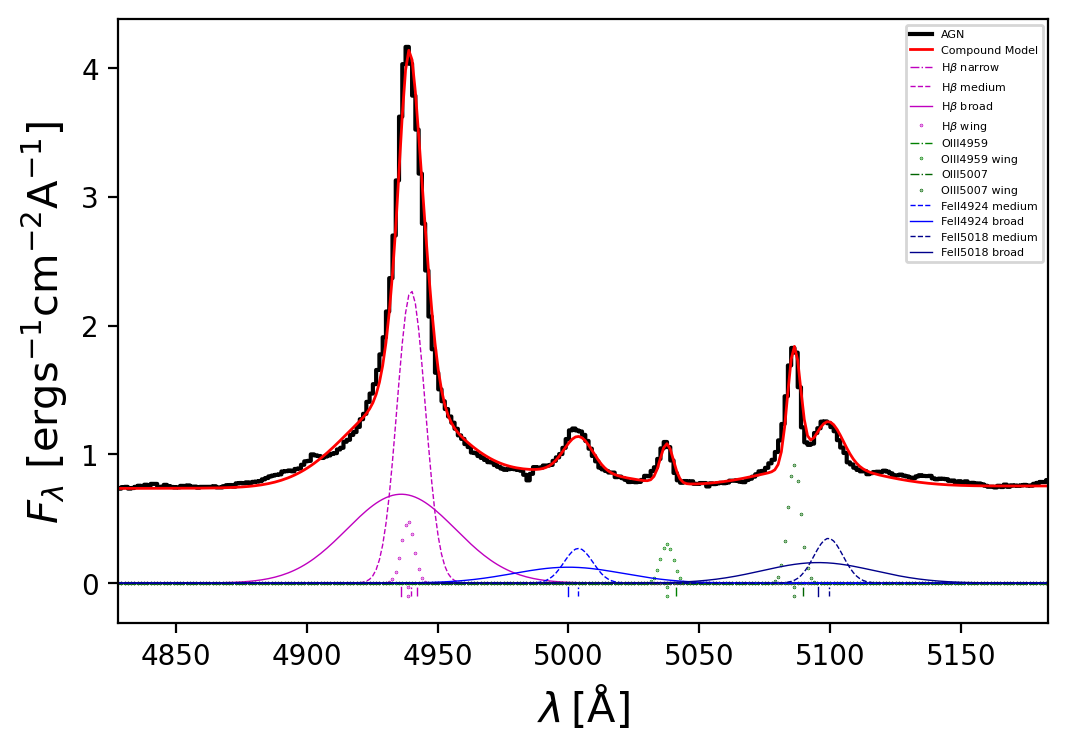

In [41]:
# %% Plot the individual lines

fig = plt.figure(figsize=(6, 4), dpi=200)

plt.step(x+1.25/2, y, c='k', label='AGN')
plt.plot(x, y_continuum*u.Jy + y_fit, '-', linewidth=1, c='red', label=r'Compound Model')

plt.plot(x, Hbeta_narrow_fit, '-.', linewidth=0.5, c='m', label=r'H$\beta$ narrow')
plt.plot(x, Hbeta_medium_fit, '--', linewidth=.5, c='m', label=r'H$\beta$ medium')
plt.plot(x, Hbeta_broad_fit, '-', linewidth=.5, c='m', label=r'H$\beta$ broad')
plt.plot(x, Hbeta_wing_fit, '.', markersize=0.5, c='m', label=r'H$\beta$ wing')

plt.plot(x, OIII4959_fit, '-.', linewidth=.5, c='green', label=r'OIII4959')
plt.plot(x, OIII4959_wing_fit, '.', markersize=.5, c='green', label=r'OIII4959 wing')
plt.plot(x, OIII5007_fit, '-.', linewidth=.5, c='darkgreen', label=r'OIII5007')
plt.plot(x, OIII5007_wing_fit, '.', markersize=.5, c='darkgreen', label=r'OIII5007 wing')

plt.plot(x, FeII4924_medium_fit, '--', linewidth=.5, c='blue', label=r'FeII4924 medium')
plt.plot(x, FeII4924_broad_fit, '-', linewidth=.5, c='blue', label=r'FeII4924 broad')
plt.plot(x, FeII5018_medium_fit, '--', linewidth=.5, c='darkblue', label=r'FeII5018 medium')
plt.plot(x, FeII5018_broad_fit, '-', linewidth=.5, c='darkblue', label=r'FeII5018 broad')


# draw line positions

plt.plot([g_fit[0].mean.value, g_fit[0].mean.value], [-.1, -.03], '-.', linewidth=.5, color='m')
plt.plot([g_fit[3].mean.value, g_fit[3].mean.value], [-.1, -.03], '--', linewidth=.5, color='m')
plt.plot([g_fit[6].mean.value, g_fit[6].mean.value], [-.1, -.03], '-', linewidth=.5, color='m')
plt.plot([g_fit[9].mean.value, g_fit[9].mean.value], [-.1, -.03], '.', markersize=.5, color='m')

plt.plot([g_fit[1].mean.value, g_fit[1].mean.value], [-.1,-.03], '-.', linewidth=.5, c='green')
plt.plot([g_fit[2].mean.value, g_fit[2].mean.value], [-.1,-.03], '-.', linewidth=.5, c='darkgreen')
plt.plot([g_fit[10].mean.value, g_fit[10].mean.value], [-.1,-.03], '.', markersize=.5, c='green')
plt.plot([g_fit[11].mean.value, g_fit[11].mean.value], [-.1,-.03], '.', markersize=.5, c='darkgreen')

plt.plot([g_fit[4].mean.value, g_fit[4].mean.value], [-.1, -.03], '--', linewidth=.5, color='blue')
plt.plot([g_fit[5].mean.value, g_fit[5].mean.value], [-.1, -.03], '--', linewidth=.5, color='darkblue')
plt.plot([g_fit[7].mean.value, g_fit[7].mean.value], [-.1, -.03], '-', linewidth=.5, color='blue')
plt.plot([g_fit[8].mean.value, g_fit[8].mean.value], [-.1, -.03], '-', linewidth=.5, color='darkblue')


plt.legend(fontsize=4)
plt.xlim(fit_range[0].value, fit_range[1].value)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)
#plt.savefig('Figures/'+objectname+'_1x1_px.png', dpi=200, bbox_inches='tight')

In [144]:
print(g_fit)

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4] + [5] + [6] + [7] + [8] + [9] + [10] + [11]
Components: 
    [0]: <Gaussian1D(amplitude=0.61133251 Jy, mean=4938.56785839 nm, stddev=2.4536939 nm)>

    [1]: <Gaussian1D(amplitude=0.31321728 Jy, mean=5037.6961375 nm, stddev=2.50294511 nm)>

    [2]: <Gaussian1D(amplitude=0.93965184 Jy, mean=5086.38966139 nm, stddev=2.52713816 nm)>

    [3]: <Gaussian1D(amplitude=2.2497812 Jy, mean=4940.23475025 nm, stddev=5.33842286 nm)>

    [4]: <Gaussian1D(amplitude=0.30922908 Jy, mean=5004.22505575 nm, stddev=5.40757085 nm)>

    [5]: <Gaussian1D(amplitude=0.39890551 Jy, mean=5099.88740353 nm, stddev=5.51094368 nm)>

    [6]: <Gaussian1D(amplitude=0.58579491 Jy, mean=4936.53097548 nm, stddev=23.01738337 nm)>

    [7]: <Gaussian1D(amplitude=0.09073947 Jy, mean=5000.47330641 nm, stddev=23.31552495 nm)>

    [8]: <Gaussian1D(amplitude=0.11705391 Jy, mean=5096.06393456 nm, stddev=23.76123189 nm

In [143]:
# Save file for Spectroastrometry Analysis

In [18]:
from astropy.table import Table
import astropy.units as u
import numpy as np

line = np.array(['Hbeta_narrow', 'Hbeta_medium', 'Hbeta_broad', 'Hbeta_wing',
                  'OIII4959', 'OIII4959_wing', 
                  'OIII5007', 'OIII5007_wing', 
                  'FeII4924_medium', 'FeII4924_broad', 
                  'FeII5018_medium', 'FeII5018_broad', ])

t = Table([['amplitude', 'mean', 'stddev'],
           g_fit[0].parameters, g_fit[3].parameters, g_fit[6].parameters, g_fit[9].parameters,
             g_fit[1].parameters, g_fit[10].parameters, 
             g_fit[2].parameters, g_fit[11].parameters,
             g_fit[4].parameters, g_fit[7].parameters, 
             g_fit[5].parameters, g_fit[8].parameters],
           
            names=('parameter',  'Hbeta_narrow', 'Hbeta_medium', 'Hbeta_broad', 'Hbeta_wing',
                                  'OIII4959', 'OIII4959_wing', 
                                  'OIII5007', 'OIII5007_wing', 
                                  'FeII4924_medium', 'FeII4924_broad', 
                                  'FeII5018_medium', 'FeII5018_broad')
          )

output = 'Data/'+dirname1 +objectname+'.central_fit.fits'
#t.write(output, overwrite=True)

In [14]:
v_narrow = ((fit_spectrum.model[0].mean.value-Hbeta_sys)/ Hbeta_sys) *3e5
v_medium = ((fit_spectrum.model[3].mean.value-Hbeta_sys)/ Hbeta_sys) *3e5
v_broad = ((fit_spectrum.model[6].mean.value-Hbeta_sys)/ Hbeta_sys) *3e5
v_wing = (fit_spectrum.model[9].mean.value-Hbeta_sys)/ Hbeta_sys *3e5

sigma_narrow = ((fit_spectrum.model[0].stddev.value)/2.35/ Hbeta_sys) *3e5
sigma_medium = ((fit_spectrum.model[3].stddev.value)/2.35/ Hbeta_sys) *3e5
sigma_broad = ((fit_spectrum.model[6].stddev.value)/2.35/ Hbeta_sys) *3e5
sigma_wing = (fit_spectrum.model[9].stddev.value)/2.35/ Hbeta_sys *3e5


print('%15s %.10s %.10s ' %('component ','v [kms-1]', 'σ [kms-1]'))
print('%.40s' %('-'*40))
print('%15s %8.1f %8.1f' %('broad: ' ,v_broad,  sigma_broad))
print('%15s %8.1f %8.1f' %('medium: ',v_medium, sigma_medium))
print('%15s %8.1f %8.1f' %('core: ',v_narrow, sigma_narrow))
print('%15s %8.1f %8.1f' %('wing: ',v_wing,   sigma_wing))

v_wing = -653.51
v_narrow = -144.75 

v_wing/v_narrow = 4.51
v_wing-v_narrow = -508.75


In [15]:
print('Vel difference of OIII wing and OIII narrow')
print('v2-v1 = %.2f' %(v_wing-v_narrow))

Vel difference of OIII wing and OIII narrow
v2-v1 = -508.75


In [16]:
g_fit[6].mean.value-OIII5007_sys

-152.31409917146175

In [17]:
v_wing/v_narrow

4.514637628951713